In [1]:
#import relevant libraries

#general
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#NLP
import nltk
from nltk.tokenize import RegexpTokenizer, sent_tokenize, word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import FreqDist, pos_tag

nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet')

#machine learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from xgboost import XGBClassifier

#model evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import silhouette_score

#preprocessing and pipleline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

#imbalanced data
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/andrewreusche/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#pull in the data

In [3]:
df= pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding='ISO-8859-1')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [5]:
raw_df= df[['tweet_text','is_there_an_emotion_directed_at_a_brand_or_product']]
raw_df= raw_df.dropna()
raw_df = raw_df.drop_duplicates(keep='first')
raw_df = raw_df.rename(columns={'tweet_text': 'tweet', 
                                'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion'})
raw_df['emotion'].value_counts(normalize= True)

emotion
No emotion toward brand or product    0.592613
Positive emotion                      0.327453
Negative emotion                      0.062734
I can't tell                          0.017200
Name: proportion, dtype: float64

In [6]:
rel_raw_df = raw_df[raw_df['emotion'] != "I can't tell"]
sentiment_map = {'No emotion toward brand or product': 0,
    'Positive emotion': 1,
    'Negative emotion': 0}
rel_raw_df['sentiment'] = rel_raw_df['emotion'].map(sentiment_map)
rel_raw_df['sentiment'].value_counts(normalize= True)

sentiment
0    0.666816
1    0.333184
Name: proportion, dtype: float64

rel_raw_df['tweet'][9088]

In [7]:
rel_raw_df["tweet"] = rel_raw_df["tweet"].str.lower()
rel_raw_df[:10]

,tweet,emotion,sentiment
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,Negative emotion,0
1,@jessedee know about @fludapp ? awesome ipad/i...,Positive emotion,1
2,@swonderlin can not wait for #ipad 2 also. the...,Positive emotion,1
3,@sxsw i hope this year's festival isn't as cra...,Negative emotion,0
4,@sxtxstate great stuff on fri #sxsw: marissa m...,Positive emotion,1
5,@teachntech00 new ipad apps for #speechtherapy...,No emotion toward brand or product,0
7,"#sxsw is just starting, #ctia is around the co...",Positive emotion,1
8,beautifully smart and simple idea rt @madebyma...,Positive emotion,1
9,counting down the days to #sxsw plus strong ca...,Positive emotion,1
10,excited to meet the @samsungmobileus at #sxsw ...,Positive emotion,1


word_tokenize('hello i am mark')

In [8]:
#9092 is a nonsensical symbolized tweet, drop it
rel_raw_df= rel_raw_df.drop(9092)

In [9]:
#removing usernames
rel_raw_df["tweet"]= rel_raw_df["tweet"].apply(lambda x : ' '.join(
    [w for w in x.split() if '@' not in w]).strip())

#removing hashtags
rel_raw_df["tweet"]= rel_raw_df["tweet"].apply(lambda x : ' '.join(
    [w for w in x.split() if '#' not in w]))

#use ReGex to strip the tweets down to only what we want
def strip_token(tweet):
    tweet = re.sub(r'http[s]?://\S+|www\.\S+', '', tweet) #remove all links form tweets
    tweet = re.sub(r'&amp;', 'and', tweet) #convert all instances of '&amp' to 'and'
    tweet = re.sub(r"'", "", tweet) #removes " ' " converting "can't" to "cant"
    tweet = re.sub(r'_', ' ', tweet) #removes all '_' from tweets
    tweet = re.sub(r'[^\w\s]', ' ', tweet) #removes all non word characters from tweets
    tweet = re.sub(r'\d+\w*', '', tweet) #removes all numbers or character combinations that begin with numbers 
    tweet = re.sub(r'can not', "cant", tweet) #convert all instances of 'can not' to 'cant'
    tweet = re.sub(r'will not', "wont", tweet) #convert all instances of 'will not' to 'wont'
    tweet = re.sub(r'do not', "dont", tweet) #convert all instances of 'do not' to 'dont'
    tweet = re.sub(r'\b[^a-zA-Z]+', ' ', tweet) #should strip all non standard a-z characters left over 
    tokens = word_tokenize(tweet)
    return tokens
rel_raw_df['tweet_tokenized'] = rel_raw_df['tweet'].apply(strip_token)

#preview dataset
rel_raw_df

,tweet,emotion,sentiment,tweet_tokenized
0,i have a 3g iphone. after 3 hrs tweeting at it...,Negative emotion,0,"[i, have, a, iphone, after, hrs, tweeting, at,..."
1,know about ? awesome ipad/iphone app that you'...,Positive emotion,1,"[know, about, awesome, ipad, iphone, app, that..."
2,can not wait for 2 also. they should sale them...,Positive emotion,1,"[cant, wait, for, also, they, should, sale, th..."
3,i hope this year's festival isn't as crashy as...,Negative emotion,0,"[i, hope, this, years, festival, isnt, as, cra..."
4,"great stuff on fri marissa mayer (google), tim...",Positive emotion,1,"[great, stuff, on, fri, marissa, mayer, google..."
...,...,...,...,...
9087,"yup, but i don't have a third app yet. i'm on ...",No emotion toward brand or product,0,"[yup, but, i, dont, have, a, third, app, yet, ..."
9088,ipad everywhere. {link},Positive emotion,1,"[ipad, everywhere, link]"
9089,"wave, buzz... rt we interrupt your regularly s...",No emotion toward brand or product,0,"[wave, buzz, rt, we, interrupt, your, regularl..."
9090,"google's zeiger, a physician never reported po...",No emotion toward brand or product,0,"[googles, zeiger, a, physician, never, reporte..."


#this column is just a test

monkey=' _ the big_monkey / throws a yellow/bannana _/far'

#use ReGex to strip the tweets down to only what we want
def strip_token2(tweet):
    tweet = re.sub(r'http[s]?://\S+|www\.\S+', '', tweet) #remove all links form tweets
    tweet = re.sub(r'&amp;', 'and', tweet) #convert all instances of '&amp' to 'and'
    #tweet = re.sub(r'/', ' ', tweet) #removes all '/' from tweets
    tweet = re.sub(r'_', ' ', tweet) #removes all '_' from tweets
    tweet = re.sub(r'[^\w\s]', ' ', tweet) #removes all non word characters from tweets
    tweet = re.sub(r'\d+\w*', '', tweet) #removes all numbers or character combinations that begin with numbers 
    tweet = re.sub(r'can not', "cant", tweet) #convert all instances of 'can not' to 'cant'
    tweet = re.sub(r'will not', "wont", tweet) #convert all instances of 'will not' to 'wont'
    tweet = re.sub(r'do not', "dont", tweet) #convert all instances of 'do not' to 'dont'
    tokens = word_tokenize(tweet)
    return tokens

monkey2= strip_token2(monkey)

print(monkey2)

In [10]:
#create a new column to show how long the tweets are, shorter 
rel_raw_df['tweet_len']= rel_raw_df.tweet_tokenized.apply(lambda x : len(x))
#consider getting rid of all tweets that are less than 5 characters long
rel_raw_df[rel_raw_df['tweet_len']<5]

,tweet,emotion,sentiment,tweet_tokenized,tweet_len
14,great ipad app from http://tinyurl.com/4nqv92l,Positive emotion,1,"[great, ipad, app, from]",4
52,÷¼ what? ÷_ {link} ã_,No emotion toward brand or product,0,"[what, link]",2
77,i worship {link},No emotion toward brand or product,0,"[i, worship, link]",3
85,stay tune showcase {link},No emotion toward brand or product,0,"[stay, tune, showcase, link]",4
133,follow lead {link},No emotion toward brand or product,0,"[follow, lead, link]",3
...,...,...,...,...,...
8885,well put. totally agree!,No emotion toward brand or product,0,"[well, put, totally, agree]",4
8904,black or white ipad?,No emotion toward brand or product,0,"[black, or, white, ipad]",4
8923,"google arwords, arsense anyone?",No emotion toward brand or product,0,"[google, arwords, arsense, anyone]",4
9031,... or maybe not: {link},No emotion toward brand or product,0,"[or, maybe, not, link]",4


stopwords_list= stopwords.words('english')
stopwords_list = [word for word in stopwords_list if word not in ['not', 'can']]
#possibly append words to the list of stop words
#additional_stopwords= ['google', 'iphone', 'ipad', 'link', 'apple', 'rt', 'store', 'quot', 'austin', 'via', 'sxsw']
#stopwords_list.append('additional_stopwords')

def remove_stopwords(token_list):
    list_stripped= [x for x in token_list if x not in stopwords_list]
    return list_stripped

rel_raw_df['tweet_tokenized_ns'] = rel_raw_df['tweet_tokenized'].apply(remove_stopwords)

rel_raw_df["tweet_tokenized_ns"]

rel_raw_df["tweet_tokenized_ns"][0]

In [11]:
#lemmetize the tokens
lemmatizer = WordNetLemmatizer()

def lem_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

rel_raw_df['tweet_lem'] = rel_raw_df['tweet_tokenized'].apply(lem_tokens)

In [12]:
#random undersample here 

In [13]:
X= rel_raw_df['tweet_lem']
y= rel_raw_df['sentiment']

#Train split (remain is the remaining data)
X_train, X_remain, y_train, y_remain= train_test_split(X, y, 
                                                   test_size= 0.2,  
                                                   random_state= 24)

#Val test split 
X_val, X_test, y_val, y_test= train_test_split(X_remain, y_remain,
                                               test_size= 0.5, 
                                               random_state= 24)

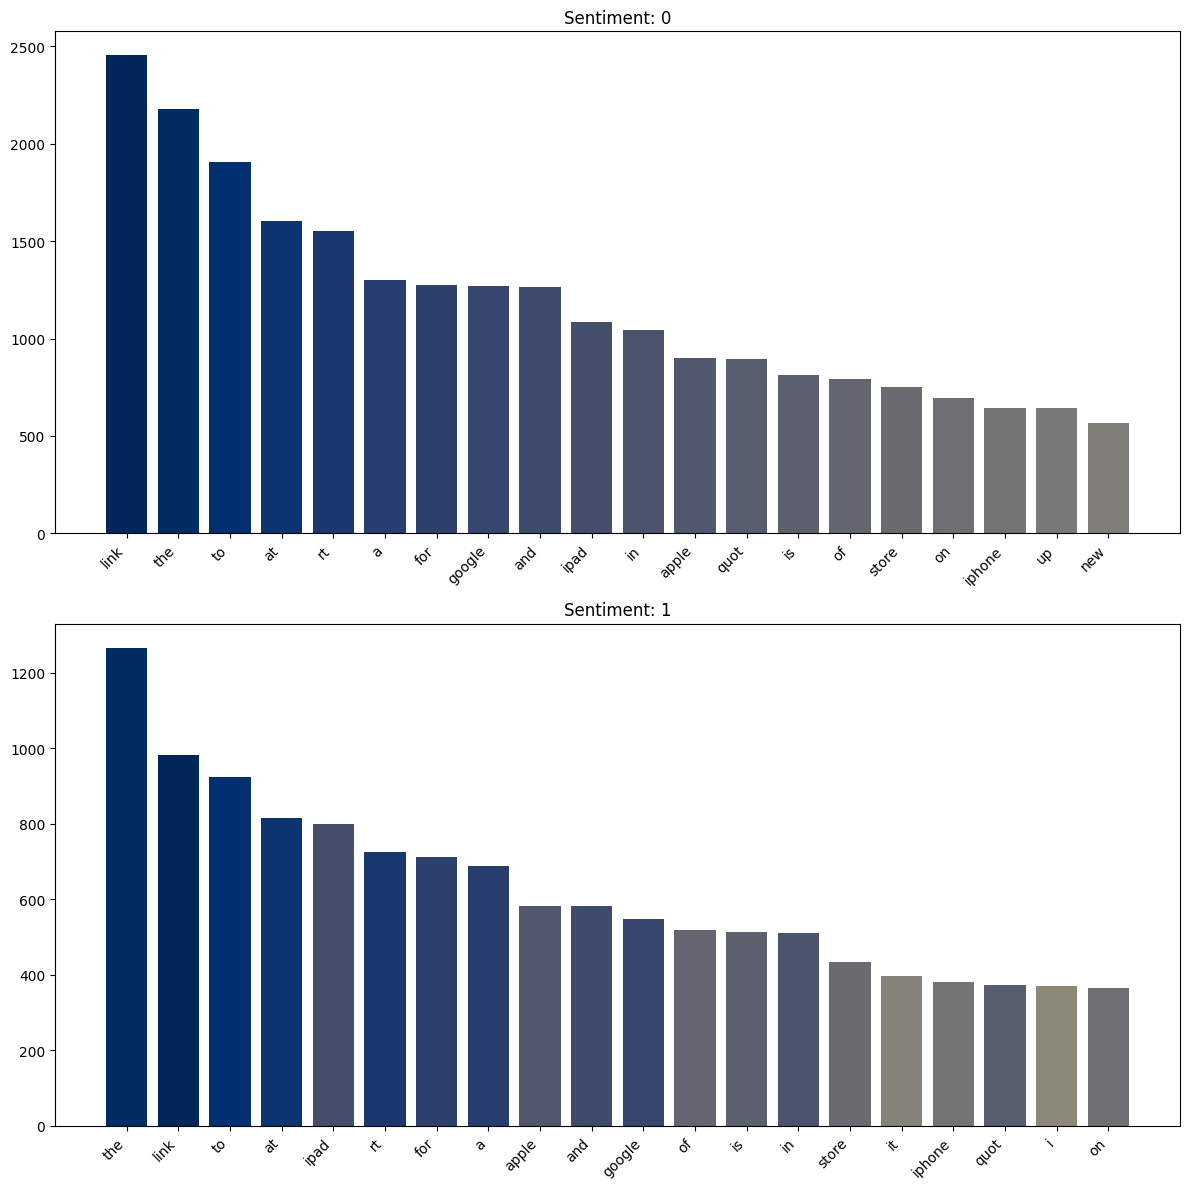

In [14]:
#check out the word distrobutions in X_train for each target class

from collections import Counter

color_palette = sns.color_palette('cividis', n_colors=38)

fig, axes = plt.subplots(nrows=2, figsize=(12, 12)) 

plotted_words_and_colors = {}

sentiment_classes = y_train.unique() 
for i, sentiment_class in enumerate(sentiment_classes):
    sentiment_data = X_train[y_train == sentiment_class]
    all_words_in_sentiment = [word for tokens in sentiment_data for word in tokens]
    top_10 = Counter(all_words_in_sentiment).most_common(20)
    
    colors = []
    
    for word, _ in top_10:
        if word not in plotted_words_and_colors:
            new_color = color_palette.pop(0)
            plotted_words_and_colors[word] = new_color
        colors.append(plotted_words_and_colors[word])
    
    ax = axes[i]
    words, counts = zip(*top_10)
    ax.bar(words, counts, color=colors)
    ax.set_title(f'Sentiment: {sentiment_class}') 
    ax.set_xticklabels(words, rotation=45, ha='right')

fig.tight_layout() 
plt.show()

In [15]:
type(X_train)

pandas.core.series.Series

In [16]:
rand_und = RandomUnderSampler(random_state=24)

X_train_str = X_train.apply(' '.join) 
X_train_resampled, y_train_resampled = rand_und.fit_resample(X_train_str.values.reshape(-1, 1), y_train)
X_train_resampled_tokens = pd.Series([sample[0].split(' ') for sample in X_train_resampled])
X_train_resampled_tokens

0       [dense, una, vuelta, por, para, ver, la, gran,...
1       [hey, folk, free, lunch, from, la, condesa, at...
2       [the, countdown, to, ha, begun, will, be, ther...
3       [rt, why, google, apple, ea, game, zynga, face...
4       [the, line, wa, too, long, the, other, day, bu...
                              ...                        
4783    [rt, ill, be, at, the, apple, store, tonight, ...
4784    [msft, panel, on, touch, interface, show, a, b...
4785    [questioner, at, just, said, quot, thanks, and...
4786    [rt, rt, yes, updated, iphone, app, ha, song, ...
4787    [the, pressure, ahem, excuse, to, buy, mount, ...
Length: 4788, dtype: object

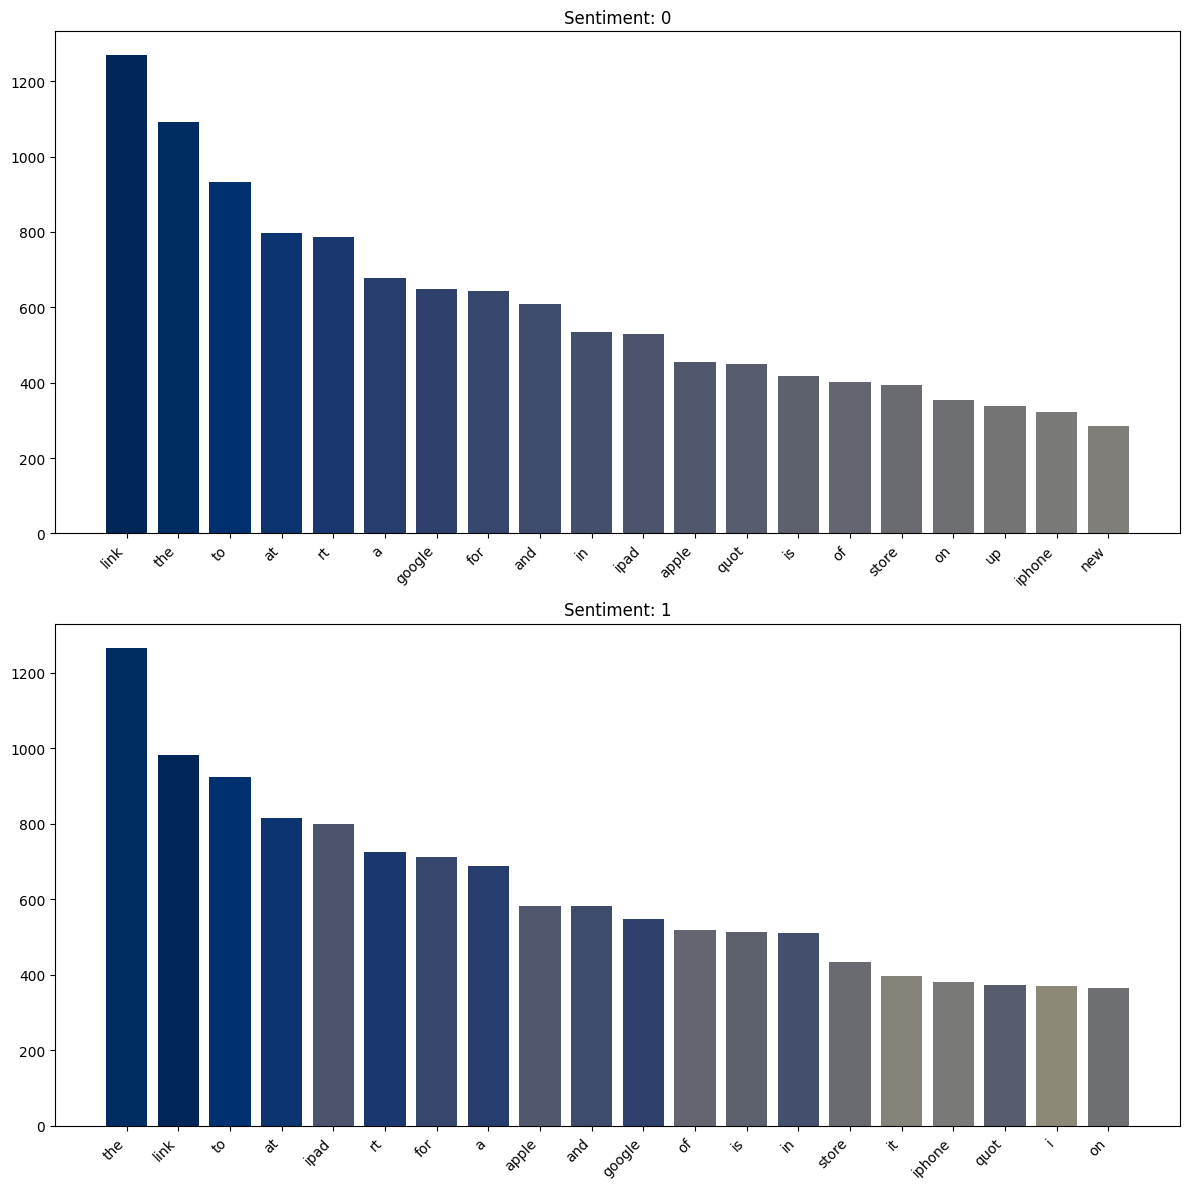

In [17]:
#check out the word distrobutions in X_train for each target class

from collections import Counter

color_palette = sns.color_palette('cividis', n_colors=38)

fig, axes = plt.subplots(nrows=2, figsize=(12, 12)) 

plotted_words_and_colors = {}

sentiment_classes = y_train.unique() 
for i, sentiment_class in enumerate(sentiment_classes):
    sentiment_data = X_train_resampled_tokens[y_train_resampled == sentiment_class]
    all_words_in_sentiment = [word for tokens in sentiment_data for word in tokens]
    top_10 = Counter(all_words_in_sentiment).most_common(20)
    
    colors = []
    
    for word, _ in top_10:
        if word not in plotted_words_and_colors:
            new_color = color_palette.pop(0)
            plotted_words_and_colors[word] = new_color
        colors.append(plotted_words_and_colors[word])
    
    ax = axes[i]
    words, counts = zip(*top_10)
    ax.bar(words, counts, color=colors)
    ax.set_title(f'Sentiment: {sentiment_class}') 
    ax.set_xticklabels(words, rotation=45, ha='right')

fig.tight_layout() 
plt.show()

In [18]:
# Join token lists into strings
X_train_str = X_train.apply(' '.join)
X_val_str = X_val.apply(' '.join)
X_test_str = X_test.apply(' '.join)

In [19]:
len(X_train_str)

7130

In [20]:
vector= TfidfVectorizer(max_features= 2000, ngram_range= (1,1), min_df= 0.0, max_df= 1.0)
vector.fit(X_train_str)

TfidfVectorizer(max_features=2000, min_df=0.0)

In [21]:
#list(vector.get_feature_names_out())

In [22]:
#vector= TfidfVectorizer(max_features= 2000, ngram_range= (1,1), min_df= .001, max_df= 1.0)
#vector.fit(X_train_str.tolist())
#list(vector.get_feature_names_out())

In [23]:
#X_train_str[0]

In [24]:
stopwords_list= stopwords.words('english')
stopwords_list = [word for word in stopwords_list if word not in ['not', 'can']]
#possibly append words to the list of stop words
additional_stopwords= ['google', 'iphone', 'ipad', 'link', 'apple', 'rt', 'store', 'quot', 'austin', 'via', 'sxsw']
stopwords_list2= stopwords_list + additional_stopwords

In [26]:
#run this on the standard X_train and y train

pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=24, 
                               C=1,
                               class_weight=None,
                               fit_intercept=True,
                               solver='saga',
                               tol=0.0001))])
#make a parameter grid
param_grid1 = {
    'tfidf__max_features': [2000, 2500, 3000, 3500, 4000],
    'tfidf__ngram_range': [(1, 1), (1,2), (2,2), (1,3), (3,3), (1,5), (5,5)],
    'tfidf__min_df': [0.0, 0.1, 0.01, 0.001, 0.0001],
    'tfidf__max_df': [0.85, 0.95, 1.0],
    'tfidf__use_idf': [True, False],
    'tfidf__stop_words': [stopwords_list2, stopwords_list, 'english', None],
    'tfidf__sublinear_tf': [True, False]}

    
#run a grid search to find the most accurate version for logistic regression
grid_search1 = GridSearchCV(
    pipeline1,
    param_grid1,
    cv=5,
    scoring='accuracy', 
    n_jobs=1,
    verbose=0)

# Fit the grid search to the training data
grid_search1.fit(X_train_str, y_train)

# Get the best train cross-validation score
best_train_cv_score = grid_search1.best_score_

# Get the best model found by grid search
best_model = grid_search1.best_estimator_

# Predict on the validation set
y_val_pred = best_model.predict(X_val_str)

# Evaluate performance (accuracy) on the validation set
from sklearn.metrics import accuracy_score
val_accuracy = accuracy_score(y_val, y_val_pred)

# Get the best hyperparameters
best_params = grid_search1.best_params_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

Best Hyperparameters: {'tfidf__max_df': 0.85, 'tfidf__max_features': 4000, 'tfidf__min_df': 0.0, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': 'english', 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7304
Validation Set Accuracy: 0.7565


In [27]:
"""

Best Hyperparameters: {'tfidf__max_df': 0.85, 'tfidf__max_features': 4000, 'tfidf__min_df': 0.0, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': 'english', 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7304
Validation Set Accuracy: 0.7565


"""

"\n\nBest Hyperparameters: {'tfidf__max_df': 0.85, 'tfidf__max_features': 4000, 'tfidf__min_df': 0.0, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': 'english', 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}\nBest Train Cross-Validation Score: 0.7304\nValidation Set Accuracy: 0.7565\n\n\n"

In [32]:
#run this on the random undersampled dataset
#this seems to hurt things

# Join token lists into strings
X_train_str_ru = X_train_resampled_tokens.apply(' '.join)
X_val_str = X_val.apply(' '.join)
X_test_str = X_test.apply(' '.join)


pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=24, 
                               C=1,
                               class_weight=None,
                               fit_intercept=True,
                               solver='saga',
                               tol=0.0001))])
#make a parameter grid
param_grid1 = {
    'tfidf__max_features': [2000, 2500, 3000, 3500],
    'tfidf__ngram_range': [(1, 1), (1,2), (2,2), (1,3), (3,3), (1,5), (5,5)],
    'tfidf__min_df': [0.0, 0.1, 0.01, 0.001, 0.0001, 0.00001],
    'tfidf__max_df': [1.0]}

#run a grid search to find the most accurate version for logistic regression
grid_search1 = GridSearchCV(
    pipeline1,
    param_grid1,
    cv=5,
    scoring='accuracy', 
    n_jobs=1,
    verbose=0)

# Fit the grid search to the training data
grid_search1.fit(X_train_str_ru, y_train_resampled)

# Get the best train cross-validation score
best_train_cv_score = grid_search1.best_score_

# Get the best model found by grid search
best_model = grid_search1.best_estimator_

# Predict on the validation set
y_val_pred = best_model.predict(X_val_str)

# Evaluate performance (accuracy) on the validation set
val_accuracy = accuracy_score(y_val, y_val_pred)

# Get the best hyperparameters
best_params = grid_search1.best_params_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

Best Hyperparameters: {'tfidf__max_df': 1.0, 'tfidf__max_features': 3500, 'tfidf__min_df': 0.0, 'tfidf__ngram_range': (1, 2)}
Best Train Cross-Validation Score: 0.6748
Validation Set Accuracy: 0.6891


In [ ]:
"""
Best Hyperparameters: {'tfidf__max_df': 1.0, 'tfidf__max_features': 3500, 'tfidf__min_df': 0.0, 'tfidf__ngram_range': (1, 2)}
Best Train Cross-Validation Score: 0.6748
Validation Set Accuracy: 0.6891

"""

In [35]:
print(stopwords_list2)

None


In [36]:
#run this on the adjusted stopword dataset

stopwords_list= stopwords.words('english')
stopwords_list = [word for word in stopwords_list if word not in ['not', 'can']]
#possibly append words to the list of stop words
additional_stopwords= ['google', 'iphone', 'ipad', 'link', 'apple', 'rt', 'store', 'quot', 'austin', 'via', 'sxsw']
stopwords_list2= stopwords_list + additional_stopwords

def remove_stopwords2(token_list):
    list_stripped= [x for x in token_list if x not in stopwords_list2]
    return list_stripped

rel_raw_df['tweet_tokenized_ns2']= rel_raw_df['tweet_tokenized'].apply(remove_stopwords2)

rel_raw_df['tweet_lem2'] = rel_raw_df['tweet_tokenized_ns2'].apply(lem_tokens)

X= rel_raw_df['tweet_lem2']
y= rel_raw_df['sentiment']

#Train split (remain is the remaining data)
X_train2, X_remain2, y_train, y_remain= train_test_split(X, y, 
                                                   test_size= 0.2,  
                                                   random_state= 24)

#Val test split 
X_val2, X_test2, y_val, y_test= train_test_split(X_remain2, y_remain,
                                               test_size= 0.5, 
                                               random_state= 24)

# Join token lists into strings
X_train_str2= X_train2.apply(' '.join)
X_val_str2= X_val2.apply(' '.join)
X_test_str2= X_test2.apply(' '.join)


pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=24, 
                               C=1,
                               class_weight=None,
                               fit_intercept=True,
                               solver='saga',
                               tol=0.0001))])
#make a parameter grid
param_grid1 = {
    'tfidf__max_features': [2000, 2500, 3000, 3500],
    'tfidf__ngram_range': [(1, 1), (1,2), (2,2), (1,3), (3,3), (1,5), (5,5)],
    'tfidf__min_df': [0.0, 0.1, 0.01, 0.001, 0.0001, 0.00001],
    'tfidf__max_df': [1.0]}

#run a grid search to find the most accurate version for logistic regression
grid_search1 = GridSearchCV(
    pipeline1,
    param_grid1,
    cv=5,
    scoring='accuracy', 
    n_jobs=1,
    verbose=0)

# Fit the grid search to the training data
grid_search1.fit(X_train_str2, y_train)

# Get the best train cross-validation score
best_train_cv_score = grid_search1.best_score_

# Get the best model found by grid search
best_model = grid_search1.best_estimator_

# Predict on the validation set
y_val_pred = best_model.predict(X_val_str2)

# Evaluate performance (accuracy) on the validation set
val_accuracy = accuracy_score(y_val, y_val_pred)

# Get the best hyperparameters
best_params = grid_search1.best_params_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

Best Hyperparameters: {'tfidf__max_df': 1.0, 'tfidf__max_features': 3500, 'tfidf__min_df': 0.0, 'tfidf__ngram_range': (1, 3)}
Best Train Cross-Validation Score: 0.7234
Validation Set Accuracy: 0.7430


In [28]:
X_list_1= X_train_str[:100]

In [29]:
pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=24, 
                               C=1,
                               class_weight=None,
                               fit_intercept=True,
                               solver='saga',
                               tol=0.0001))])
#make a parameter grid
param_grid1 = {
    'tfidf__max_features': [3000],
    'tfidf__ngram_range': [(1, 2)],
    'tfidf__min_df': [0.2],
    'tfidf__max_df': [0.8]}

#run a grid search to find the most accurate version for logistic regression
grid_search1 = GridSearchCV(
    pipeline1,
    param_grid1,
    cv=5,
    scoring='accuracy', 
    n_jobs=1,
    verbose=0)

grid_search1.fit(X_train_str, y_train)

# Fit the grid search to the training data
grid_search1.fit(X_train_str, y_train)

# Get the best train cross-validation score
best_train_cv_score = grid_search1.best_score_

# Get the best model found by grid search
best_model = grid_search1.best_estimator_

# Predict on the validation set
y_val_pred = best_model.predict(X_val_str)

# Evaluate performance (accuracy) on the validation set
from sklearn.metrics import accuracy_score
val_accuracy = accuracy_score(y_val, y_val_pred)

# Get the best hyperparameters
best_params = grid_search1.best_params_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

Best Hyperparameters: {'tfidf__max_df': 0.8, 'tfidf__max_features': 3000, 'tfidf__min_df': 0.2, 'tfidf__ngram_range': (1, 2)}
Best Train Cross-Validation Score: 0.6642
Validation Set Accuracy: 0.6846


In [30]:
X_list_2= X_train_str[:100]

In [31]:
X_list_2[:100]

2915              opening popup shop downtown austin link
6476    rt remember chime tweet experience central tim...
6347     rt new app store inclds uberguide sponsored link
8164                  sxsw first lecture phone turn stove
8877    crowley growing foursquare competitor facebook...
                              ...                        
8805                          loving new iphone w channel
959                        omgjk kiss ipad slap xoom link
8864    crowd austin swarm ipad launch link via sadly ...
3012    ahh wonderful news rt ipad available online or...
332     long line apple pop store ipad great marketing...
Name: tweet_lem, Length: 100, dtype: object

In [32]:
X_list_1[:100]

2915              opening popup shop downtown austin link
6476    rt remember chime tweet experience central tim...
6347     rt new app store inclds uberguide sponsored link
8164                  sxsw first lecture phone turn stove
8877    crowley growing foursquare competitor facebook...
                              ...                        
8805                          loving new iphone w channel
959                        omgjk kiss ipad slap xoom link
8864    crowd austin swarm ipad launch link via sadly ...
3012    ahh wonderful news rt ipad available online or...
332     long line apple pop store ipad great marketing...
Name: tweet_lem, Length: 100, dtype: object